In [1]:
#Import libraries======================================================================================
import glob,os
import matplotlib.pyplot as plt
import cv2
import shutil  
import numpy as np
from scipy.optimize import curve_fit
from numpy import arange, array, arctan,pi, median
import warnings
import pandas as pd
import natsort

#Adjust Image Size (just for plotting)=================================================================
plt.rcParams["figure.figsize"] = (30,20)

#Import updateXY Function==============================================================================
def updateXY(Xpoint,Ypoint,Direction,i):
    if Direction=='Up':
        xl=int(Xpoint)
        yl=int(Ypoint)-i
    if Direction=='UR':
        xl=int(Xpoint)+i
        yl=int(Ypoint)-i
    if Direction=='Right':
        xl=int(Xpoint)+i
        yl=int(Ypoint)
    if Direction=='DR':
        xl=int(Xpoint)+i
        yl=int(Ypoint)+i
    if Direction=='Down':
        xl=int(Xpoint)
        yl=int(Ypoint)+i
    if Direction=='DL':
        xl=int(Xpoint)-i
        yl=int(Ypoint)+i
    if Direction=='Left':
        xl=int(Xpoint)-i
        yl=int(Ypoint)
    if Direction=='UL':
        xl=int(Xpoint)-i
        yl=int(Ypoint)-i
    return(xl,yl)
#Import IncreaseRes2 Function

def IncreaseRes2(Image,Xpoint,Ypoint,IR_Thr,Direction):
    X_next=[]
    Y_next=[]
    Reasons=[]
    #Move and gather values
    XL_next=[]
    YL_next=[]
    Value_next=[]
    ThereIsNoAnswer=0
    for i in range(10):
        #Moving direction
        xl,yl=updateXY(Xpoint,Ypoint,Direction,i)
        #Making cordinations and values series
        XL_next=XL_next+[xl]
        YL_next=YL_next+[yl]
        try:
            Image[int(yl),int(xl)]
        except:
            ThereIsNoAnswer=1
            Reasons=Reasons+['DimentionError']
            break
        Value_next=Value_next+[Image[int(yl),int(xl)]]
        #Break If there is zero
        if Image[int(yl),int(xl)]==0:
            ThereIsNoAnswer=1
            Reasons=Reasons+['ZeroNum']
            break
        #Break if the value is decreasing   
        if len(Value_next) >1:
            if Value_next[-2]>=Value_next[-1]:
                ThereIsNoAnswer=1
                Reasons=Reasons+['Decreasing']
                break
        #Break if is more than the Threshold
        if Image[int(yl),int(xl)]>=IR_Thr:  
            if len(Value_next)==1:
                #Exception: No answer if direction has Zero
                xl,yl=updateXY(Xpoint,Ypoint,Direction,i+1)
                if Image[int(yl),int(xl)]==0:
                    ThereIsNoAnswer=1
                    Reasons=Reasons+['ZeroNum, wrong direction']
                    break
                if Value_next>Image[int(yl),int(xl)]:
                    ThereIsNoAnswer=1
                    Reasons=Reasons+['Decreasing, wrong direction']
                    break          
            Reasons=Reasons+['OK']
            break
    #Convert Value Matrix to differential value matrix 
    Converted_Value_next=Value_next.copy()
    if ThereIsNoAnswer==0:
        if len(Value_next)==1:
            Converted_Value_next[0]=IR_Thr
        if len(Value_next)>1:
            for i in range(len(Value_next)-1):
                if Converted_Value_next[i+1]>IR_Thr:
                    Converted_Value_next[i+1]=IR_Thr-Value_next[i]
                    break
                Converted_Value_next[i+1]=Value_next[i+1]-Value_next[i]
    if ThereIsNoAnswer==0:
        Cumulative_Value=[] 
        for i in range(len(Converted_Value_next)):        
            Cumulative_Value=Cumulative_Value+[XL_next[i]*Converted_Value_next[i]]
        X_next=X_next+[np.array(Cumulative_Value).sum()/IR_Thr]
        Cumulative_Value=[] 
        for i in range(len(Converted_Value_next)):
            Cumulative_Value=Cumulative_Value+[YL_next[i]*Converted_Value_next[i]]
        Y_next=Y_next+[np.array(Cumulative_Value).sum()/IR_Thr]
    if ThereIsNoAnswer==1:
        X_next=X_next+[0]
        Y_next=Y_next+[0]
        ThereIsNoAnswer=0
    return(X_next, Y_next, Reasons)

#Line equation
def objective(x, a, b):
    return a *x + b    

def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def find_reds(pic):
    red_xs=np.where(pic[:,:,0]!=pic[:,:,1])[1]
    red_ys=np.where(pic[:,:,0]!=pic[:,:,1])[0]
    return(red_xs,red_ys)
    
def morph(Img, kernel_size=(6,6)):
    kernel = np.ones(kernel_size,np.uint8) 
    Img=cv2.morphologyEx(np.array(Img), cv2.MORPH_CLOSE, kernel)
    Img=cv2.morphologyEx(np.array(Img), cv2.MORPH_OPEN, kernel)
    return(Img)

def find_anglepix(Img, Thr, YLength):
    Img2=Img.copy()
    # Find Advancing and Receding Pixels
    X=[]
    Y=[]
    for y in np.arange(Img.shape[0]-YLength,Img.shape[0]):
        for x in range(Img.shape[1]):
             if Img[y,x,0] > Thr:
                Img2[y,x,:]=[0,0,255]
                X=X+[x]
                Y=Y+[y]
                break
    return(X,Y,Img2)

def increase_res(Img ,X, Y, IR_Thr, Dir='Right'):
    X_updated=[]
    for x in range(len(X)):
        x_updated=IncreaseRes2(Img[:,:,0],X[x],Y[x],IR_Thr,Dir)[0]
        X_updated=X_updated+x_updated
    return(X_updated)

def fit_line(X_updated,Y):
    popt, _ = curve_fit(objective, X_updated, max(Y)-np.array(Y))
    a, b = popt
    x_line = np.arange(min(X_updated), max(X_updated), .00001)
    y_line = objective(x_line, a, b)
    return(x_line, y_line)

def angle_calc(x_line,y_line):
    if len(x_line)!=0:
        dx=x_line[1]-x_line[0]
        dy=y_line[1]-y_line[0]
        gradian=arctan((dy)/(dx))
        if dy*dx<0:
            Rdegree=180+gradian*180/pi
        if dy*dx>0:
            Rdegree=gradian*180/pi
    else:
        Rdegree=90
    return(Rdegree)
        

In [16]:
import glob
import os
import matplotlib
import cv2
import shutil
import numpy as np
from scipy import __version__ as scipy_version
import warnings
import pandas as pd
import natsort

# Print version of each library
print(f"glob: Built-in module (no version)")
print(f"os: Built-in module (no version)")
print(f"matplotlib: {matplotlib.__version__}")
print(f"cv2: {cv2.__version__}")
print(f"shutil: Built-in module (no version)")
print(f"numpy: {np.__version__}")
print(f"scipy: {scipy_version}")
print(f"pandas: {pd.__version__}")
print(f"natsort: {natsort.__version__}")


glob: Built-in module (no version)
os: Built-in module (no version)
matplotlib: 3.8.0
cv2: 4.10.0
shutil: Built-in module (no version)
numpy: 1.26.4
scipy: 1.11.4
pandas: 2.1.4
natsort: 8.4.0


In [15]:
#What is the file address 
ad=os.getcwd()

#What is the file name
vidcap = cv2.VideoCapture(ad+"\\"+'example.avi')
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#Convert Video to Frames
#For chirag: if you did it once, please skip this cell for next time
SelectingRate=1
success,image = vidcap.read()
count=0
Num=0
NewFolder=ad+"\\"+"Frames"
try:
    os.makedirs(NewFolder)
except:
    shutil.rmtree(NewFolder)
    os.makedirs(NewFolder)
NewFolder=ad+"\\"+"Frames"
print('Frame Selecting+++++++++++++++++++++++++++++++++++++++++++++++++',end='\n')
while True:
    count += SelectingRate
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, count)
    success,image = vidcap.read()
    if count%SelectingRate!=0:
        continue
    try:
        Num+=1
        print(Num,':',count,end=' __ ')
        cv2.imwrite(NewFolder+"\\"+"%d.tif" % count, image)
    except:
        break

Frame Selecting+++++++++++++++++++++++++++++++++++++++++++++++++
1 : 1 __ 2 : 2 __ 3 : 3 __ 4 : 4 __ 5 : 5 __ 6 : 6 __ 7 : 7 __ 8 : 8 __ 9 : 9 __ 10 : 10 __ 11 : 11 __ 12 : 12 __ 13 : 13 __ 14 : 14 __ 15 : 15 __ 16 : 16 __ 17 : 17 __ 18 : 18 __ 19 : 19 __ 20 : 20 __ 21 : 21 __ 22 : 22 __ 23 : 23 __ 24 : 24 __ 25 : 25 __ 26 : 26 __ 27 : 27 __ 28 : 28 __ 29 : 29 __ 30 : 30 __ 31 : 31 __ 32 : 32 __ 33 : 33 __ 34 : 34 __ 35 : 35 __ 36 : 36 __ 37 : 37 __ 38 : 38 __ 39 : 39 __ 40 : 40 __ 41 : 41 __ 42 : 42 __ 43 : 43 __ 44 : 44 __ 45 : 45 __ 46 : 46 __ 47 : 47 __ 48 : 48 __ 49 : 49 __ 50 : 50 __ 51 : 51 __ 52 : 52 __ 53 : 53 __ 54 : 54 __ 55 : 55 __ 56 : 56 __ 57 : 57 __ 58 : 58 __ 59 : 59 __ 60 : 60 __ 61 : 61 __ 62 : 62 __ 63 : 63 __ 64 : 64 __ 65 : 65 __ 66 : 66 __ 67 : 67 __ 68 : 68 __ 69 : 69 __ 70 : 70 __ 71 : 71 __ 72 : 72 __ 73 : 73 __ 74 : 74 __ 75 : 75 __ 76 : 76 __ 77 : 77 __ 78 : 78 __ 79 : 79 __ 80 : 80 __ 81 : 81 __ 82 : 82 __ 83 : 83 __ 84 : 84 __ 85 : 85 __ 86 : 86 __ 87 : 87

In [6]:
Thr=80             #object detection threshold 60-120
IR_Thr=160         #subpixel threshold 120-200
YLength=10         #number of selected pixels for CA measurement
noise_kernel=(6,6) #noise handling kernel

up_margin=150      #margin to cut drop image from upside
right_margin=25    #margin to cut drop image from rightside
left_margin=25     #margin to cut drop image from leftside

In [14]:
#Make folders
NewFolder_left=ad+"\\"+"Frames\\left"
try:
    os.makedirs(NewFolder_left)
except:
    shutil.rmtree(NewFolder_left)
    os.makedirs(NewFolder_left)
    
NewFolder_right=ad+"\\"+"Frames\\right"
try:
    os.makedirs(NewFolder_right)
except:
    shutil.rmtree(NewFolder_right)
    os.makedirs(NewFolder_right)

#Load and find reds
pic1=cv2.imread(ad+"\\Frames\\slope\\1.bmp")
pic2=cv2.imread(ad+"\\Frames\\slope\\2.bmp")
red1_xs,red1_ys=find_reds(pic1)
red2_xs,red2_ys=find_reds(pic2)

#which red blongs to which drop
x1_left=min(red1_xs)
x1_right=max(red1_xs)
y1_left= red1_ys[red1_xs==x1_left]
y1_right= red1_ys[red1_xs==x1_right]

x2_left=min(red2_xs)
x2_right=max(red2_xs)
y2_left= red2_ys[red2_xs==x2_left]
y2_right= red2_ys[red2_xs==x2_right]

#LEFT+++++++++++++++++++++++++++++++++++++
#calculate the angle and yline
dx=x2_left-x1_left
dy=y2_left-y1_left
gradian=np.arctan((dy)/(dx))
angle_left=gradian*180/np.pi

rotated1_left=rotate_image(pic1, angle_left[0])
rotated2_left=rotate_image(pic2, angle_left[0])


#which red blongs to which drop
xs_1_left, ys_1_left=find_reds(rotated1_left)
xs_2_left, ys_2_left=find_reds(rotated2_left)
y_left=min(ys_1_left)
x_end_left=max(xs_1_left[ys_1_left==y_left])
x_start_left=min(xs_2_left[ys_2_left==y_left])

#save visual
rotated1_left[y_left-up_margin,:,:]=[0,0,255]
rotated1_left[y_left,:,:]=[0,0,255]
rotated1_left[:,x_start_left-left_margin,:]=[0,0,255]
rotated1_left[:,x_end_left+right_margin,:]=[0,0,255]
rotated2_left[y_left-up_margin,:,:]=[0,0,255]
rotated2_left[y_left,:,:]=[0,0,255]
rotated2_left[:,x_start_left-left_margin,:]=[0,0,255]
rotated2_left[:,x_end_left+right_margin,:]=[0,0,255]

cv2.imwrite(NewFolder_left+"\\0rotated1.tif", rotated1_left)
cv2.imwrite(NewFolder_left+"\\0rotated2.tif", rotated2_left)
#RIGHT+++++++++++++++++++++++++++++++++++++
#calculate the angle and yline
dx=x2_right-x1_right
dy=y2_right-y1_right
gradian=np.arctan((dy)/(dx))
angle_right=gradian*180/np.pi

rotated1_right=rotate_image(pic1, angle_right[0])
rotated1_right = cv2.flip(rotated1_right, 1)
rotated2_right=rotate_image(pic2, angle_right[0])
rotated2_right = cv2.flip(rotated2_right, 1)

#which red blongs to which drop
xs_1_right, ys_1_right=find_reds(rotated1_right)
xs_2_right, ys_2_right=find_reds(rotated2_right)
y_right=min(ys_1_right)
x_end_right=max(xs_1_right[ys_1_right==y_right])
x_start_right=min(xs_2_right[ys_2_right==y_right]) 

#save visual
rotated1_right[y_right-up_margin,:,:]=[0,0,255]
rotated1_right[y_right,:,:]=[0,0,255]
rotated1_right[:,x_start_right-left_margin,:]=[0,0,255]
rotated1_right[:,x_end_right+right_margin,:]=[0,0,255]
rotated2_right[y_right-up_margin,:,:]=[0,0,255]
rotated2_right[y_right,:,:]=[0,0,255]
rotated2_right[:,x_start_right-left_margin,:]=[0,0,255]
rotated2_right[:,x_end_right+right_margin,:]=[0,0,255]

cv2.imwrite(NewFolder_right+"\\0rotated1.tif", rotated1_right)
cv2.imwrite(NewFolder_right+"\\0rotated2.tif", rotated2_right)
#Temp pic analysis+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


FileName=sorted(os.listdir(ad+"\\"+"Frames"))
FileNames=[]
for i in range(len(FileName)):
    try:
        if FileName[i].split(".")[1]=="tif":
            FileNames=FileNames+[FileName[i]]
    except:
        pass
FileNames=natsort.natsorted(FileNames)

x_left_list=[]
x_right_list=[]
angle_left_list=[]
angle_right_list=[]
I=[]
file_names=[]
for i in range(len(FileNames)):
    pic_temp=cv2.imread(ad+"\\Frames\\"+FileNames[i])
    pic_temp=morph(pic_temp, kernel_size=noise_kernel)
    pic_temp=255-pic_temp

    #Left angle and vel
    pic_temp_left=rotate_image(pic_temp, angle_left[0])
    pic_temp_left=pic_temp_left[y_left-up_margin:y_left,x_start_left-left_margin:x_end_left+right_margin,:]
    X_left,Y_left,pic_temp2_left= find_anglepix(pic_temp_left, Thr, YLength)
    X_updated_left=increase_res(pic_temp_left ,X_left, Y_left, IR_Thr, Dir='Right')
    x_line_left, y_line_left=fit_line(X_updated_left,Y_left)
    left_angle=angle_calc(x_line_left,y_line_left)

    x_left_list=x_left_list+[np.mean(x_line_left)]
    angle_left_list=angle_left_list+[left_angle]
    cv2.imwrite(NewFolder_left+"\\"+FileNames[i], pic_temp2_left)


    #Right angle and vel
    pic_temp_right=rotate_image(pic_temp, angle_right[0])
    pic_temp_right = cv2.flip(pic_temp_right, 1)
    pic_temp_right=pic_temp_right[y_right-up_margin:y_right,x_start_right-left_margin:x_end_right+right_margin,:]
    X_right,Y_right,pic_temp2_right= find_anglepix(pic_temp_right, Thr, YLength)
    X_updated_right=increase_res(pic_temp_right ,X_right, Y_right, IR_Thr, Dir='Right')
    x_line_right, y_line_right=fit_line(X_updated_right,Y_right)
    right_angle=angle_calc(x_line_right,y_line_right)

    x_right_list=x_right_list+[np.mean(x_line_right)]
    angle_right_list=angle_right_list+[right_angle]
    cv2.imwrite(NewFolder_right+"\\"+FileNames[i], pic_temp2_right)
    
    I=I+[i]
    file_names=file_names+[int(FileNames[i].split(".")[0])]

v_right_list=[]
for i in range(len(x_right_list)-1):
    v_right_list=v_right_list+[np.abs(x_right_list[i+1]-x_right_list[i])]
    
v_left_list=[]
for i in range(len(x_left_list)-1):
    v_left_list=v_left_list+[np.abs(x_left_list[i+1]-x_left_list[i])]

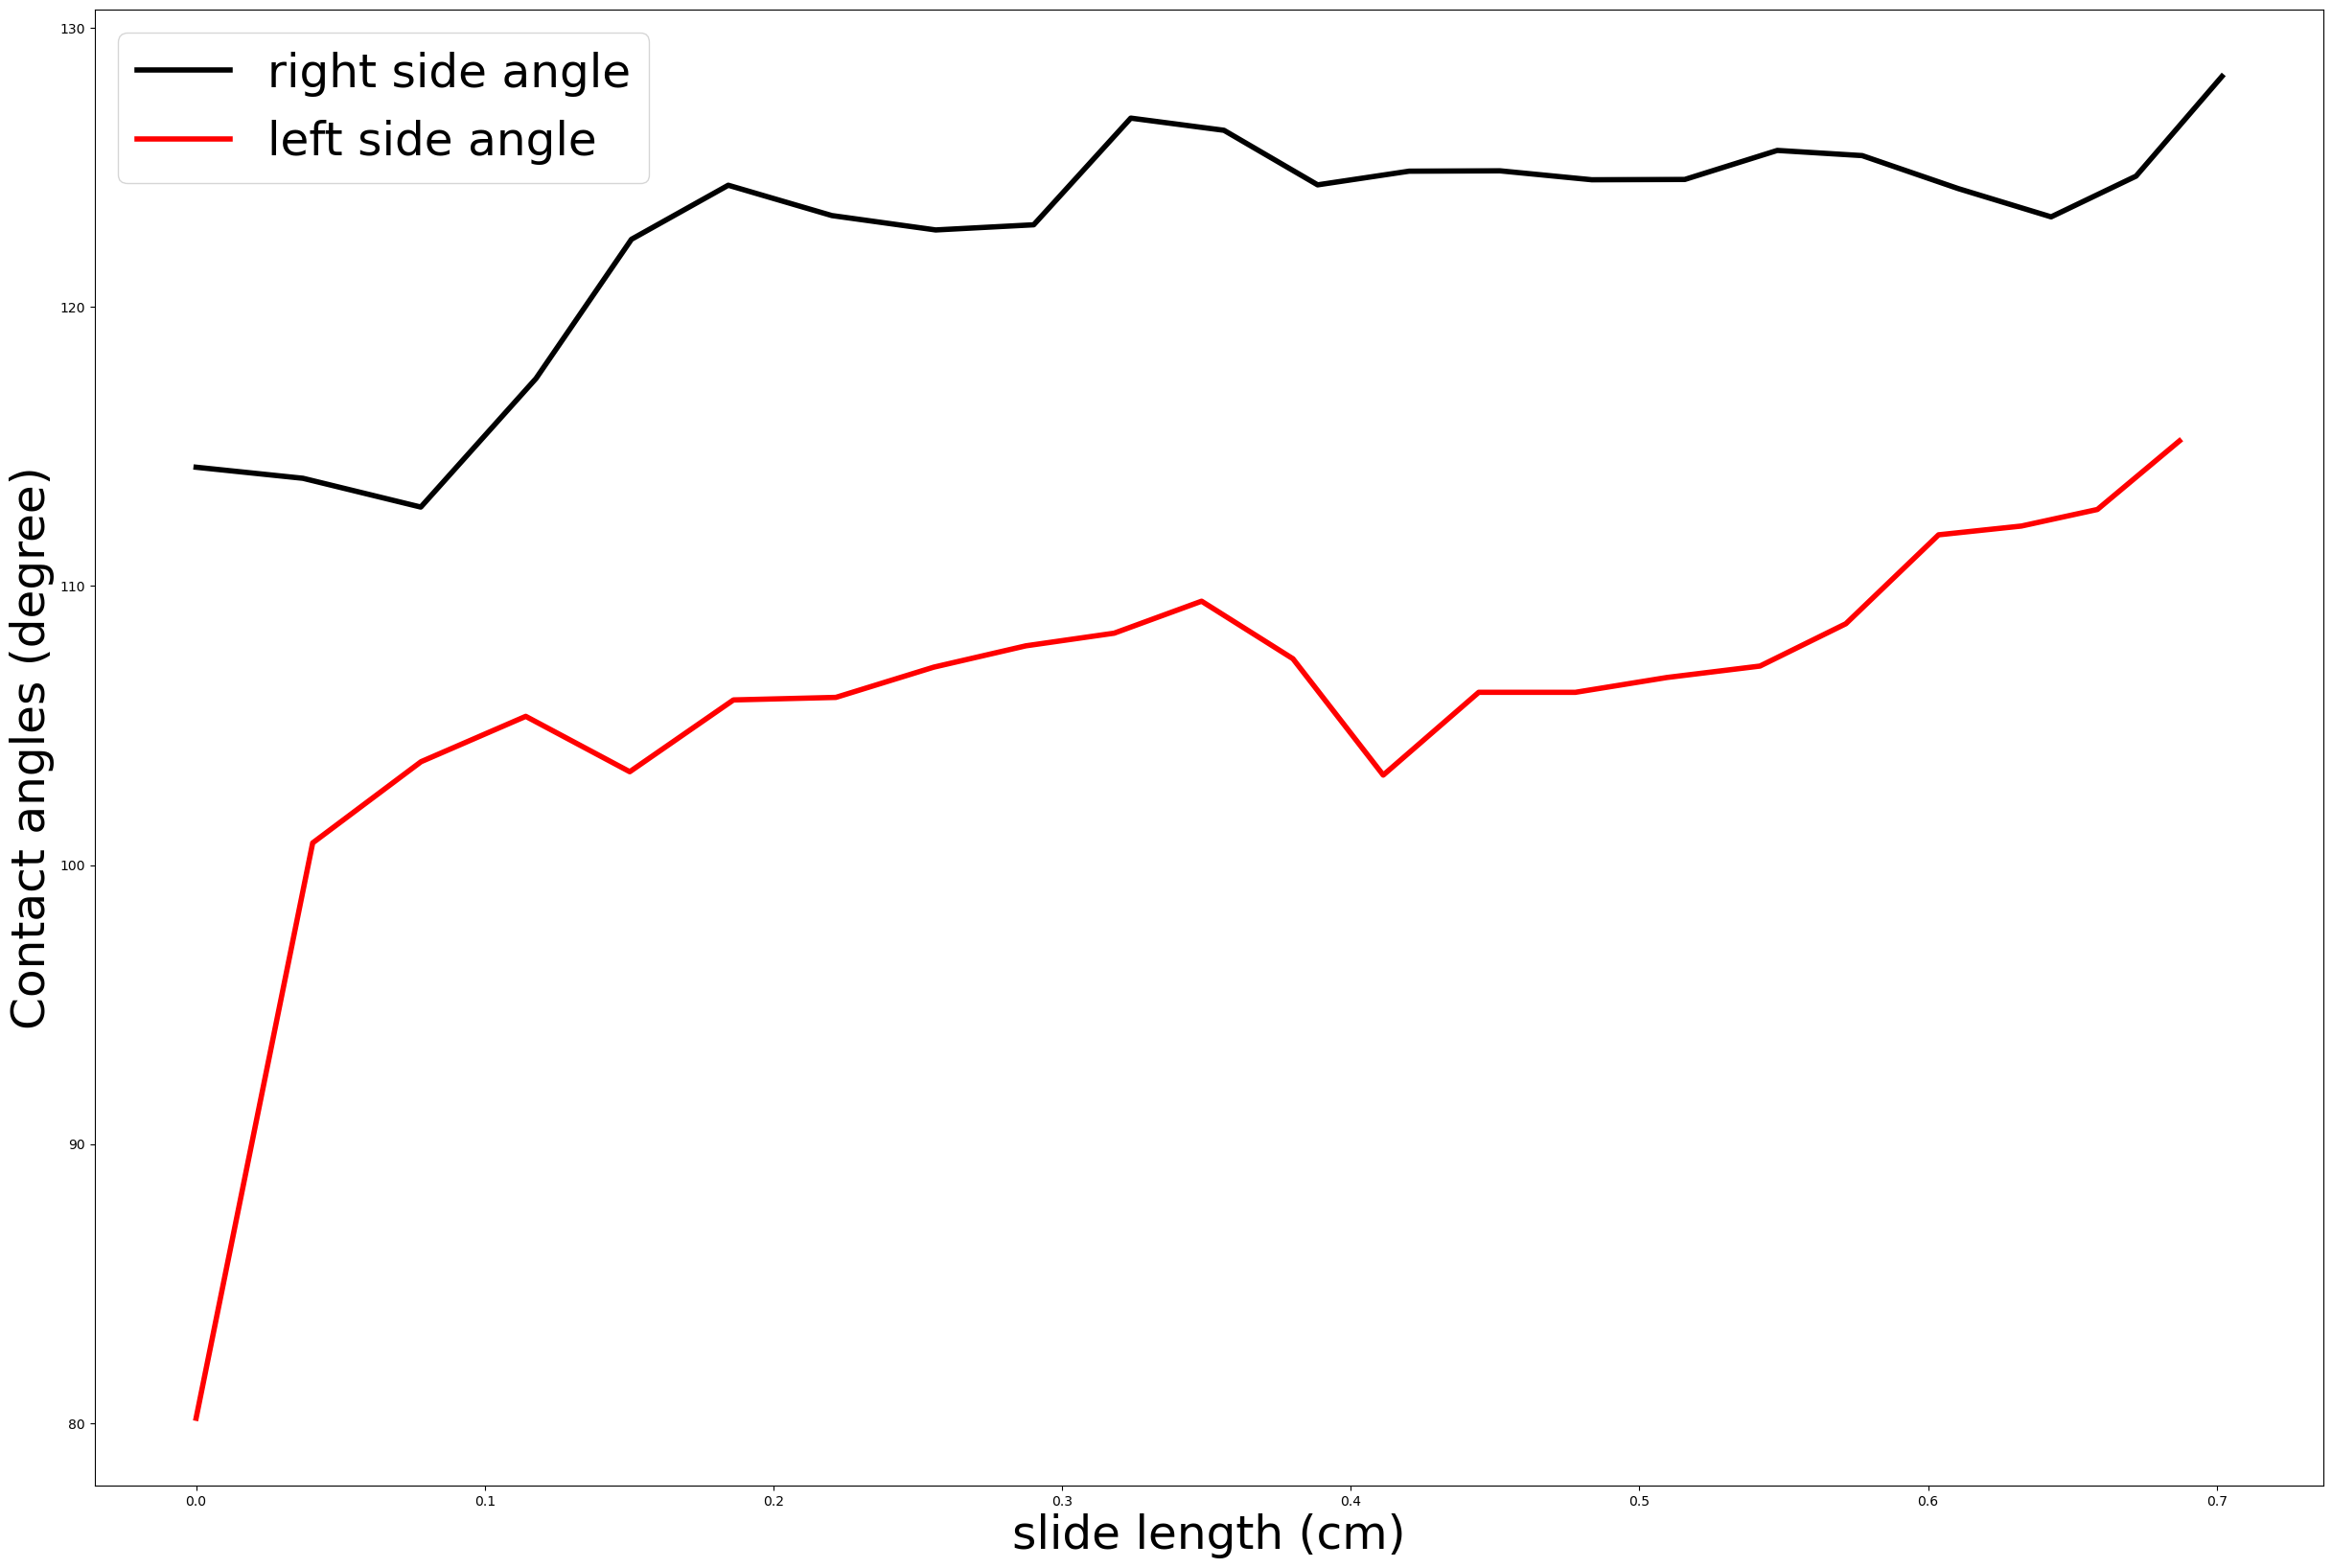

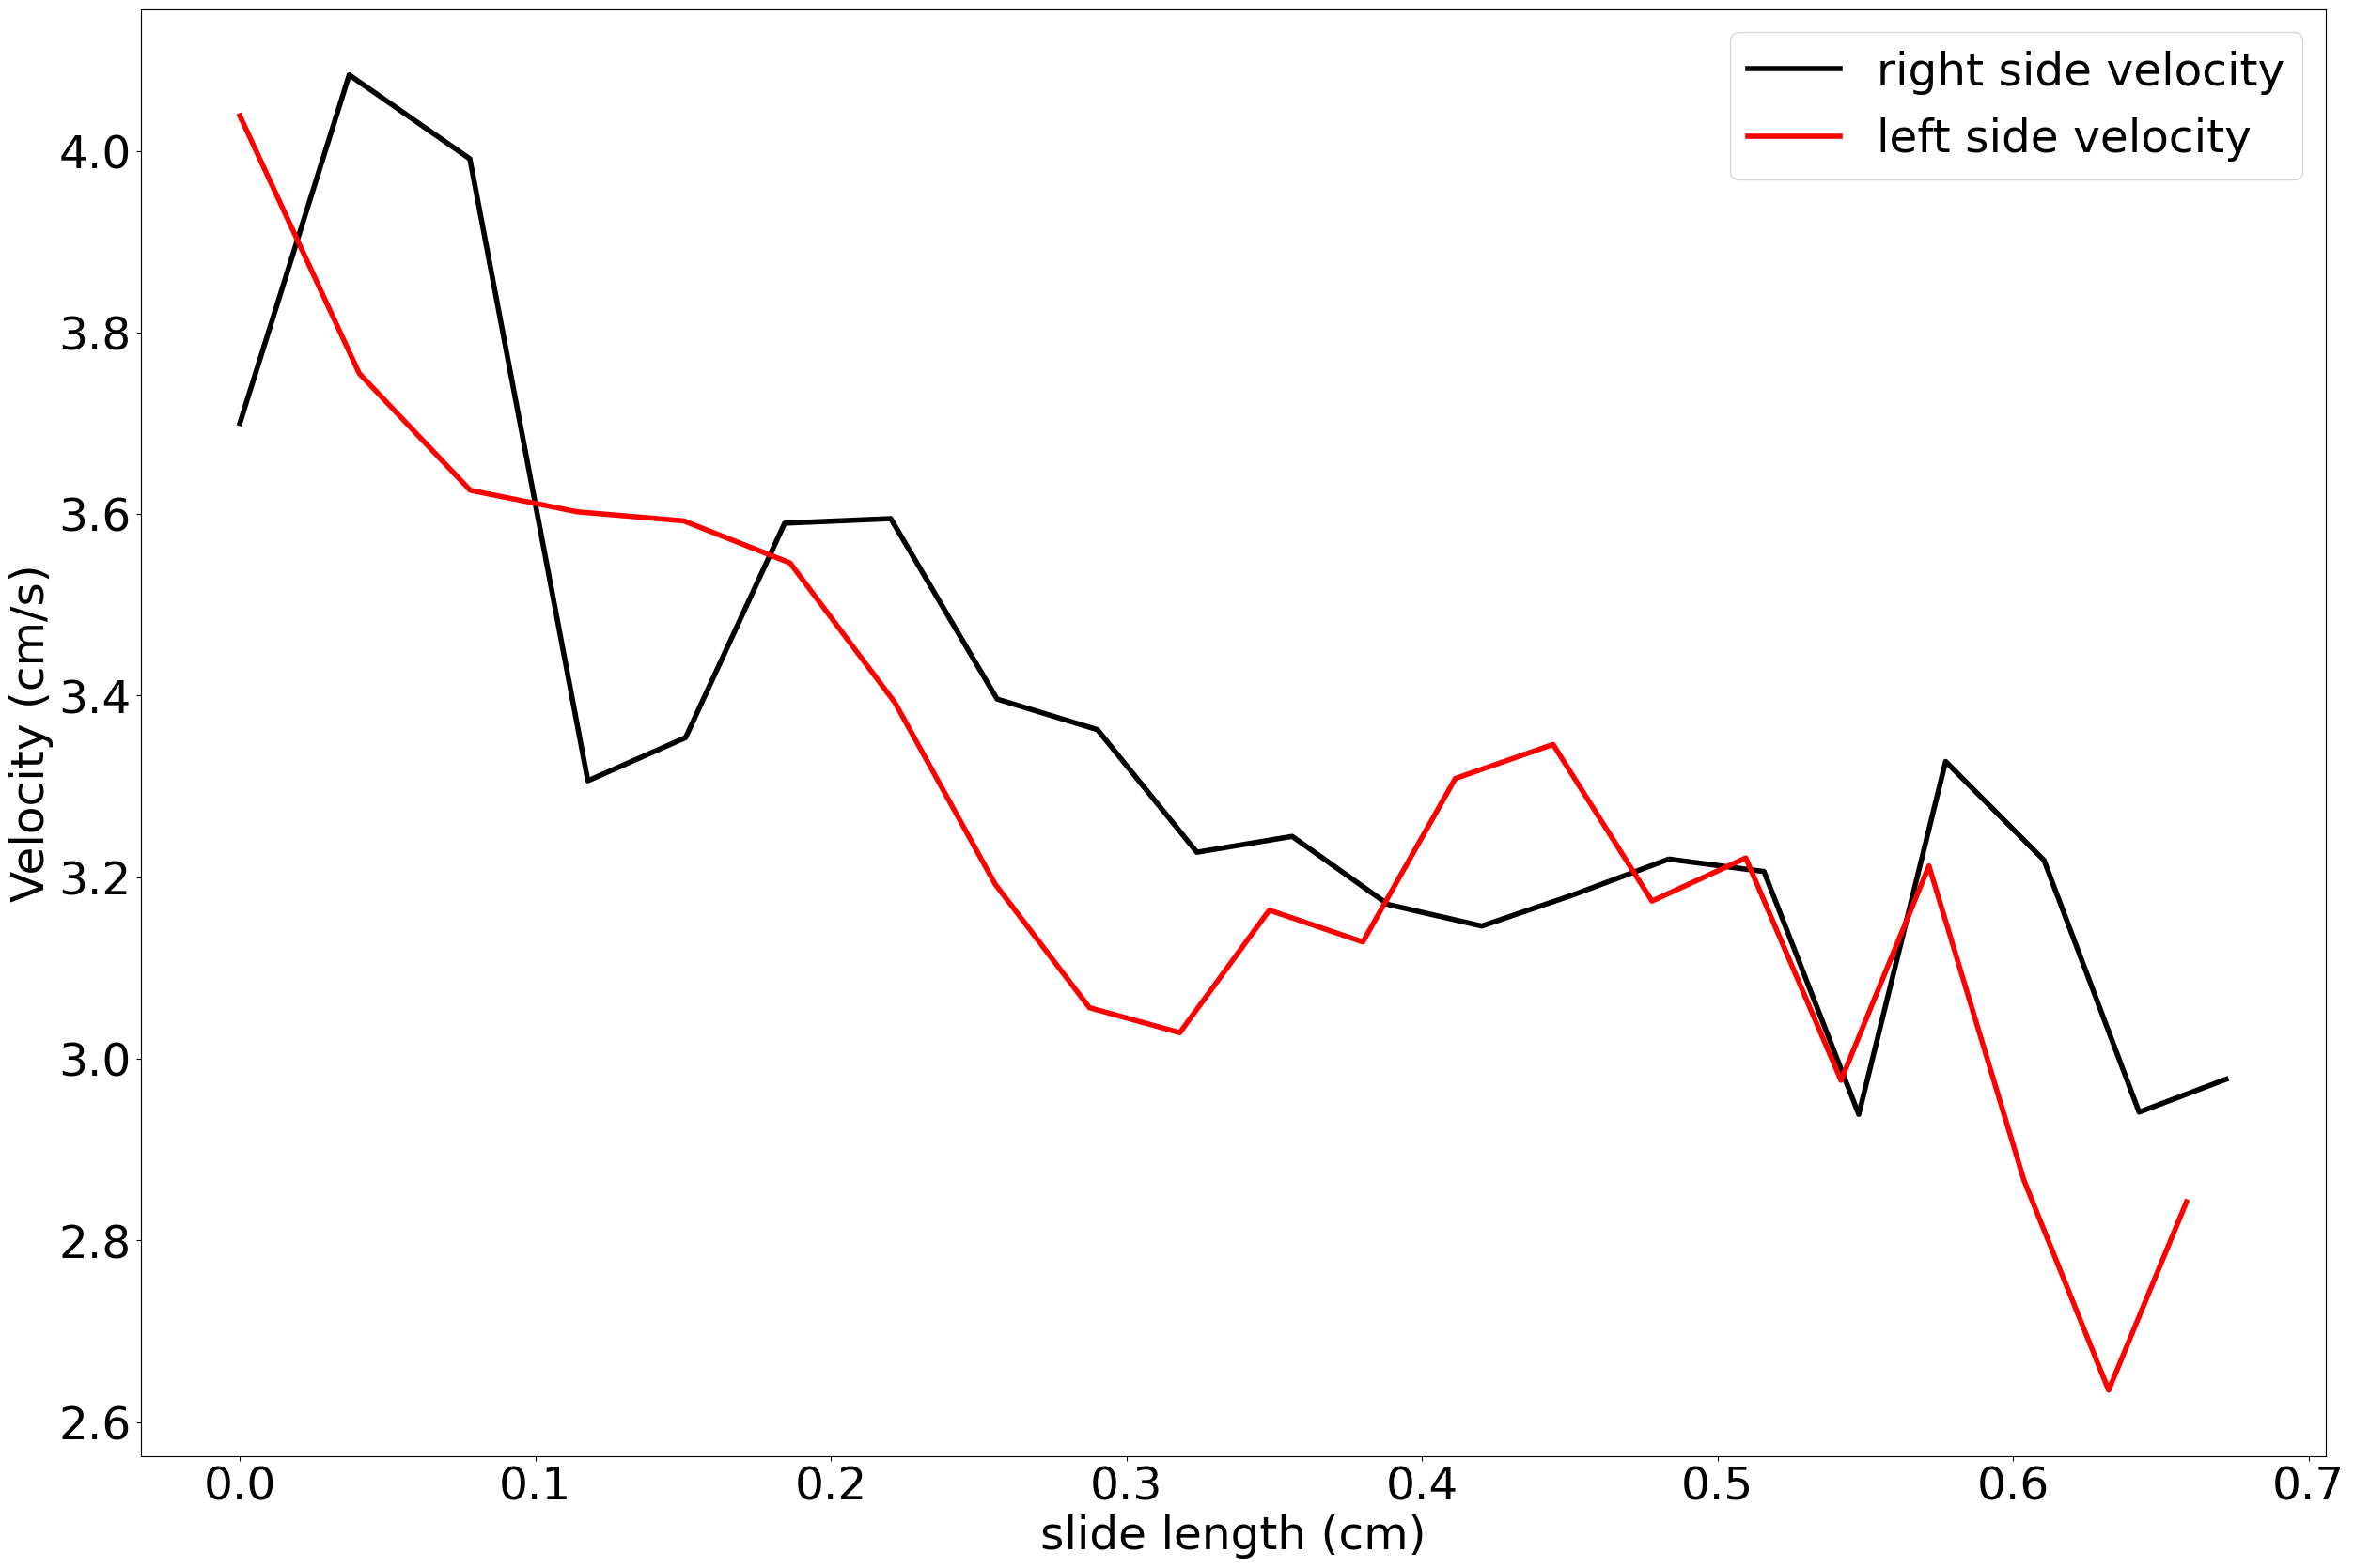

In [15]:
pixel_cm= 250 #how many pixel in a cm?
fps=100

x_right_list_cm=np.array(x_right_list)/pixel_cm
x_left_list_cm=np.array(x_left_list)/pixel_cm
x_right_list_cm=max(x_right_list_cm)-x_right_list_cm
x_left_list_cm=max(x_left_list_cm)-x_left_list_cm

plt.plot(x_right_list_cm, angle_right_list, color="black", linewidth=4, label="right side angle")
plt.plot(x_left_list_cm, angle_left_list, color="red", linewidth=4, label="left side angle")

plt.rc('xtick', labelsize=35) 
plt.rc('ytick', labelsize=35) 
font_size=35
plt.xlabel('slide length (cm)',fontdict={'size':font_size})
plt.ylabel('Contact angles (degree)',fontdict={'size':font_size})
plt.legend(fontsize=font_size)
plt.savefig(ad+"\\Frames\\"+"results CAs.png") 
plt.show()




v_right_list=[]
for i in range(len(x_right_list_cm)-1):
    v_right_list=v_right_list+[np.abs(x_right_list_cm[i+1]-x_right_list_cm[i])]
    
v_left_list=[]
for i in range(len(x_left_list_cm)-1):
    v_left_list=v_left_list+[np.abs(x_left_list_cm[i+1]-x_left_list_cm[i])]

v_right_list=np.array(v_right_list)*fps
v_left_list=np.array(v_left_list)*fps

plt.plot(x_right_list_cm[:-1], v_right_list, color="black", linewidth=4, label="right side velocity")
plt.plot(x_left_list_cm[:-1], v_left_list, color="red", linewidth=4, label="left side velocity")

plt.rc('xtick', labelsize=35) 
plt.rc('ytick', labelsize=35) 
font_size=35
plt.xlabel('slide length (cm)',fontdict={'size':font_size})
plt.ylabel('Velocity (cm/s)',fontdict={'size':font_size})
plt.legend(fontsize=font_size)
plt.savefig(ad+"\\Frames\\"+"results velocity.png") 
plt.show()

pd.DataFrame([I, file_names, x_right_list_cm, x_left_list_cm, angle_left_list, angle_right_list, v_left_list, v_right_list],index=["number", "file number", "x_right_list (cm)", "x_left_list (cm)","angle left", "angle right", "velocity left (cm/s)", "velocity right (cm/s)"]).T.to_excel(ad+"\\Frames\\"+"results.xlsx")